In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.optimize import minimize
import corner
import scipy.io as sp_io
import scipy.integrate as sp_int
import importlib
import torus as t
import constants as const
from copy import deepcopy
from astropy.io import fits
import stellar_spectra as ss
from flatstar import draw
import scipy.special as sp_special
import scipy.stats as sp_stats

 ChiantiPy version 0.15.0 
 found PyQt5 widgets
 using PyQt5 widgets


In [2]:
smith_data = pd.read_excel('he_ew_smith_table1.xlsx', usecols = [0, 1, 2, 4, 6], names = ['Star', 'EW', 'log(Lx/Lbol)', 'logRhk', 'B-V'])

Text(0.5, 0, 'log $L_{\\mathrm{x}}/L_{\\mathrm{bol}}$')

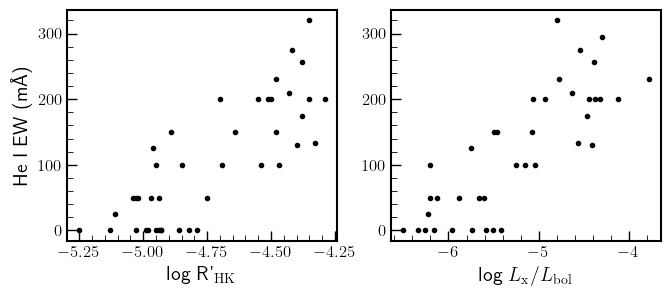

In [3]:
#the trend found in smith only applies to stars with B-V > 0.47

stars = smith_data[smith_data['B-V'] > 0.47]

fig, ax = plt.subplots(1, 2, figsize=(23/3, 3))
ax[0].plot(stars['logRhk'], stars['EW'], color = 'black', linestyle='', marker = '.')
ax[0].set_xlabel('log R\'' + r'$_{\mathrm{HK}}$')
ax[0].set_ylabel('He I EW (m\AA)')
#fig.savefig('paper_plots/logRhk_vs_HeEW_stars.pdf', bbox_inches='tight')

#fig1, ax1 = plt.subplots(figsize=(10/3, 3))
ax[1].plot(stars['log(Lx/Lbol)'], stars['EW'], color = 'black', linestyle='', marker = '.')
ax[1].set_xlabel(r'log $L_{\mathrm{x}}/L_{\mathrm{bol}}$')
#ax[1].set_ylabel('He I EW (m\AA)')

#fig.savefig('paper_plots/HeEW_corr.pdf', bbox_inches='tight')

In [7]:
#basic helium profiles of star

#central wavelength 
wav1, wav2 = 0.00010833217, 0.00010833307
f1, f2 = 0.17974, 0.29958
wavc = (f1*wav1 + f2*wav2) / (f1 + f2)

#standard deviation of gaussian
def line_width(T):
    lw = np.sqrt(const.kb * T / 4 / const.mp / const.c**2) * wavc
    return lw

#gaussian profile
def profile(wav, EW, T):
    amplitude = EW / np.sqrt(2 * np.pi) / line_width(T)
    return 1 - amplitude * np.exp(-(wav - wavc)**2 / (2 * line_width(T)**2))

def voigt_profile(wav, EW, T, Gamma):
    w, wc = const.c / wav, const.c / wavc
    sigma = np.sqrt(const.kb * T / 4 / const.mp / const.c**2) * wc
    gamma = Gamma / 4 * np.pi
    return EW*sp_special.voigt_profile(w-wc, sigma, gamma)
    


#doppler shift
def dwav(wav0, v):
    return -wav0*v/const.c

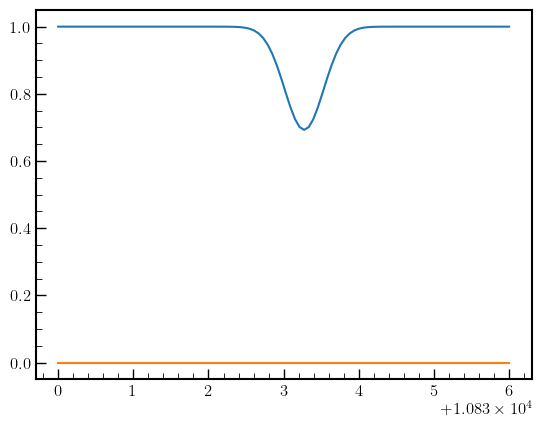

In [6]:
wavl = np.linspace(0.00010830, 0.00010836, 100)
plt.plot(wavl*1e8, profile(wavl, 200*1e-11, 2.5*10**4))
plt.plot(wavl*1e8, voigt_profile(wavl, 200*1e-11, 2.5*10**4, 1.021e7))

In [61]:
def Fx2Feuv(samples):
    Lx = samples['Lbol'] * const.Lbol_sun * 10**samples['log(Lx/Lbol)']
    Fx = Lx / (4 * np.pi * samples['radius']**2 * const.r_sun**2)
    Feuv = 460 * Fx**(1 - 0.425)
    Feuvp = Feuv * samples['radius']**2 * const.r_sun**2 / samples['ap']**2
    return Feuvp 


def get_lines_EW(samples, species, species_state, lines, wavs):

    #star grid
    flux_map_oot = draw.star(100, supersampling=10).intensity

    #EW array
    EWs = np.zeros((len(samples), len(species_state)))

    for i, sample in samples.iterrows():

        #stellar spectrum
        base_spectrum = ss.stellar_spectra(sample['stellar_type'], semi_major_axis = sample['ap'] / (sample['radius']*const.r_sun), Lbol=sample['Lbol'])
        norm_spectrum = base_spectrum.get_rescaled_spectrum(norm_wav=[1.24e-6, 9.12e-6], norm_flux=sample['Feuvp']) 

        #disk properties
        T=np.float64(10**4)
        cs = np.sqrt(const.kb * T / (2 * const.mp))
        Lcor = 1e6 * sample['period'] * const.day / 2 * np.pi #cs * sample['period'] * const.day / 4 / np.pi
        disk = t.Torus(species=species, stellar_spectrum=norm_spectrum, Ms=sample['mass']*const.m_sun, Rs=sample['radius']*const.r_sun, ap=sample['ap'], T=T, Rtorus=[sample['ap'], sample['ap']+Lcor], i=np.pi/2, tau=5)

        #print(disk.species_ion_abundances)

        #get_EW
        for j, line in enumerate(lines):
            i_line, tau_line = disk.do_transit(species_state[j], lines[j], wavs[j], flux_map_oot)
            #plt.plot(wavs[j], i_line)
            #plt.show()
            EWs[i,j]=disk.get_EW(species_state[j], lines[j], wavs[j], flux_map_oot)  #, stellar_line=stellar_lines[j])

    return EWs
        
    
def get_he3_EW(samples, show_plots=False):

    EWobs = []

    for i, star in samples.iterrows():
        base_spectrum = ss.stellar_spectra(star['stellar_type'], semi_major_axis = star['ap'] / (star['radius']*const.r_sun), Lbol=star['Lbol'])
        norm_spectrum = base_spectrum.get_rescaled_spectrum(norm_wav=[1.24e-6, 9.12e-6], norm_flux=star['Feuvp']) 
        Lcor = 1e6 * star['period'] * const.day / 2 * np.pi
        torus = t.Torus(species={'h' : 1, 'he': 0.09}, stellar_spectrum=norm_spectrum, Ms=star['mass']*const.m_sun, Rs=star['radius']*const.r_sun, ap=star['ap'], T=1.0*10**4, Rtorus=[star['ap'], star['ap']+Lcor], i=np.pi/2, tau=0.1)
        i_he3, tau_he3 = torus.do_transit('he_1', ['he_3-2', 'he_3-1', 'he_3-0'], wav, flux_map_oot)
        stellar_he3_profile = profile(wav, star['EW']*1e-11, 2.5e4)
        obs_profile = stellar_he3_profile*i_he3
        EWobs.append(sp_int.trapezoid(1 - obs_profile, wav) * 1e11)

        if show_plots==True:
             plt.plot(wav, obs_profile, 'blue')
             plt.plot(wav, i_he3, 'black')
             plt.plot(wav, stellar_he3_profile, 'red')
             plt.show()
            
    samples['EWobs'] = EWobs

def get_c2_EW(samples, show_plots=False):

    EWobs = []
    wav_c2 = np.linspace(1.334e-5, 1.335e-5, 30)

    for i, star in samples.iterrows():
        base_spectrum = ss.stellar_spectra(star['stellar_type'], semi_major_axis = star['ap'] / (star['radius']*const.r_sun), Lbol=star['Lbol'])
        norm_spectrum = base_spectrum.get_rescaled_spectrum(norm_wav=[1.24e-6, 9.12e-6], norm_flux=star['Feuvp']) 
        Lcor = 1e6 * star['period'] * const.day / 2 * np.pi
        torus = t.Torus(species={'h' : 1, 'he': 0.09, 'c' : 1e-4}, stellar_spectrum=norm_spectrum, Ms=star['mass']*const.m_sun, Rs=star['radius']*const.r_sun, ap=star['ap'], T=1.0*10**4, Rtorus=[star['ap'], star['ap']+Lcor], i=np.pi/2, tau=0.1)
        i_c2, tau_c2 = torus.do_transit('c_2', ['c2_1335'], wav_c2, flux_map_oot)
        EWobs.append(sp_int.trapezoid(1 - i_c2, wav_c2) * 1e11)

        if show_plots==True:
             plt.plot(wav_c2, i_c2, 'black')
             plt.show()
            
    samples['EWc2'] = EWobs

def get_na1_EW(samples, show_plots=False):

    EWobs = []
    wav_na = np.linspace(5.8892e-05, 5.8907e-5, 50)

    for i, star in samples.iterrows():
        base_spectrum = ss.stellar_spectra(star['stellar_type'], semi_major_axis = star['ap'] / (star['radius']*const.r_sun), Lbol=star['Lbol'])
        norm_spectrum = base_spectrum.get_rescaled_spectrum(norm_wav=[1.24e-6, 9.12e-6], norm_flux=star['Feuvp']) 
        Lcor = 1e6 * star['period'] * const.day / 2 * np.pi
        torus = t.Torus(species={'h' : 1, 'he': 0.09, 'c' : 1e-4, 'na' : 1e-6}, stellar_spectrum=norm_spectrum, Ms=star['mass']*const.m_sun, Rs=star['radius']*const.r_sun, ap=star['ap'], T=1.0*10**4, Rtorus=[star['ap'], star['ap']+Lcor], i=np.pi/2, tau=10)
        print(torus.species_ion_abundances)
        i_na, tau_na = torus.do_transit('na_1', ['na_5890'], wav_na, flux_map_oot)
        EWobs.append(sp_int.trapezoid(1 - i_na, wav_na) * 1e11)

        if show_plots==True:
             plt.plot(wav_na, i_na, 'black')
             plt.show()
            
    samples['EWna'] = EWobs



In [60]:
cut_stars = stars[stars['logRhk'].notna() & stars['log(Lx/Lbol)'].notna()] 
m=50

#sample of K stars
Kstars = cut_stars.sample(n=m, replace=True, random_state=7325890, ignore_index=True)
Kstars.drop(columns=['Star', 'B-V'])

#mass, bolometric luminosity
Kmass = np.random.default_rng(seed=13240).uniform(0.4, 0.908, m)
Kstars['mass'] = Kmass
Kstars['radius'] = 1.06 * Kmass**0.945   #Demircan and Kahraman 1990
Kstars['Lbol'] = 1.02 * Kmass**3.92
Kstars['stellar_type'] = ['late-K' if m < 0.746 else 'early-K' for m in Kmass]

#planetary orbital period
Kperiod = np.random.default_rng(seed=132914022).uniform(1, 3, m)
Kstars['period'] = Kperiod
Kstars['ap'] = (const.G * Kstars['mass'] * const.m_sun * Kstars['period']**2 * const.day**2 / 4 / np.pi**2)**(1/3)

#EUV flux
Kstars['Feuvp'] = Fx2Feuv(Kstars)

#sample of G stars
Gstars = cut_stars.sample(n=m, replace=True, random_state=1903284, ignore_index=True)
Gstars.drop(columns=['Star', 'B-V'])

#mass, bolometric luminosity
Gmass = np.random.default_rng(seed=837205).uniform(0.908, 1.14, m)
Gstars['mass'] = Gmass
Gstars['radius'] = 1.06 * Gmass**0.945   #Demircan and Kahraman 1990
Gstars['Lbol'] = 1.02 * Gmass**3.92
Gstars['stellar_type'] = ['late-G' if m < 0.963 
                           else 'solar' if m < 1.04 
                           else 'early-G' 
                           for m in Gmass]
    
#planetary orbital period
Gperiod = np.random.default_rng(seed=281047).uniform(1, 3, m)
Gstars['period'] = Gperiod
Gstars['ap'] = (const.G * Gstars['mass'] * const.m_sun * Gstars['period']**2 * const.day**2 / 4 / np.pi**2)**(1/3)

#EUV flux
Gstars['Feuvp'] = Fx2Feuv(Gstars)

#sample of F stars
Fstars = cut_stars.sample(n=m, replace=True, random_state=294536, ignore_index=True)
Fstars.drop(columns=['Star', 'B-V'])

#mass, bolometric luminosity
Fmass = np.random.default_rng(seed=81698123).uniform(1.14, 1.3, m)
Fstars['mass'] = Fmass
Fstars['radius'] = 1.06 * Fmass**0.945   #Demircan and Kahraman 1990
Fstars['Lbol'] = 1.02 * Fmass**3.92
Fstars['stellar_type'] = ['late-F' for m in Gmass]
    
#planetary orbital period
Fperiod = np.random.default_rng(seed=92037546).uniform(1, 3, m)
Fstars['period'] = Fperiod
Fstars['ap'] = (const.G * Fstars['mass'] * const.m_sun * Fstars['period']**2 * const.day**2 / 4 / np.pi**2)**(1/3)

#EUV flux
Fstars['Feuvp'] = Fx2Feuv(Fstars)

In [55]:
w3 = 3.889751e-05
w3up = w3 + dwav(w3, 1e7)
w3d = w3 - dwav(w3, 1e7)

print(w3d)
print(w3up)



3.891048491911004e-05
3.888453508088996e-05


In [24]:
species

{'h': 1.0,
 'he': 0.08394599865193965,
 'c': 0.000295120922666639,
 'ca': 1.8620871366628656e-06,
 'fe': 2.818382931264455e-05,
 'na': 1.8620871366628656e-06,
 'al': 2.6302679918953817e-06,
 'o': 0.0005370317963702533,
 'mg': 3.3113112148259076e-05}

In [62]:
#solar element ratio

solar_abundance = pd.read_excel('../SolarSystemAbundances_Lodders2021.xlsx', usecols = [1, 11], names = ['Element', 'Abundance'], skiprows=3, dtype={'Element':'string'}) #in astronomical abundance

#change to abundance relative to hydrogen
solar_abundance['Abundance'] = 10**(solar_abundance['Abundance'] - 12)
sa = dict(zip(solar_abundance['Element'], solar_abundance['Abundance']))
sola =  {k.lower(): v for k, v in sa.items()}
species_keys = ['h', 'he', 'c', 'ca', 'fe', 'na', 'al', 'o', 'mg']
species = dict((k, sola[k]) for k in species_keys)
species_state = ['he_1', 'he_1', 'c_2', 'ca_2', 'fe_2', 'na_1', 'al_2', 'o_1', 'c_3', 'c_4', 'mg_2']
lines = [['he_3-2', 'he_3-1', 'he_3-0'], ['he_32-2', 'he_32-1', 'he_32-0'], ['c2_1335'], ['ca2_h'], ['fe2_2600'], ['na_5890'], ['al2_1670'], ['o1_1302'], ['c3_977'], ['c4_1548'], ['mg2_h']]
wvls = [np.linspace(1.0830e-4, 1.0836e-4, 100),
        np.linspace(3.8884095227659365e-05, 3.891048491911004e-05, 100),
        np.linspace(1.334e-5, 1.335e-5, 100), 
        np.linspace(3.9335e-5, 3.9360e-5, 100),
        np.linspace(2.5993056685346406e-05, 2.601040331465359e-05, 100),
        np.linspace(5.8879853080489675e-05, 5.8919146919510327e-05, 100),
        np.linspace(1.6702296808766137e-05, 1.6713443191233865e-05, 100),
        np.linspace(1.3017336399479635e-05, 1.3026023600520364e-05, 100),
        np.linspace(9.766940985356417e-06, 9.773459014643584e-06, 100),
        np.linspace(1.5476705761699857e-05, 1.5487034238300142e-05, 100),
        np.linspace(2.7954172303946095e-05, 2.7972827696053907e-05, 100)]



EWsK=get_lines_EW(Kstars, species, species_state, lines, wvls) 

0.5432321334344847
0.14791083881682077
3.6726999710092043
0.043203547579455555
0.14791083881682077
0.2920918299500736
0.3004104489948929
0.14791083881682077
2.031023901953083
0.05531052390979955
0.14791083881682077
0.3739450357542662
0.33501712855764765
0.14791083881682077
2.2649937708253245
0.04578454768170887
0.14791083881682077
0.3095415322362579
0.12655121279509585
0.14791083881682077
0.8555912048597222
0.5725533720543068
0.14791083881682077
3.87093587349188
0.5336398243179243
0.14791083881682077
3.6078480021251664
0.03326082680408093
0.14791083881682077
0.2248707874970041
0.06114244492824612
0.14791083881682077
0.4133736608982902
0.22453551766564483
0.14791083881682077
1.5180464086456802
0.04057348209088136
0.14791083881682077
0.2743104049401635
0.028477895551287453
0.14791083881682077
0.192534203572165
0.3073909347066448
0.14791083881682077
2.078217777449908
0.06192352763341392
0.14791083881682077
0.41865442809166076
0.23099740765713286
0.14791083881682077
1.5617341467666892
0.05

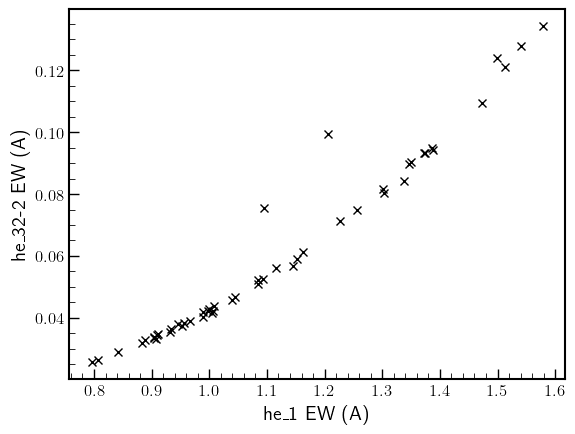

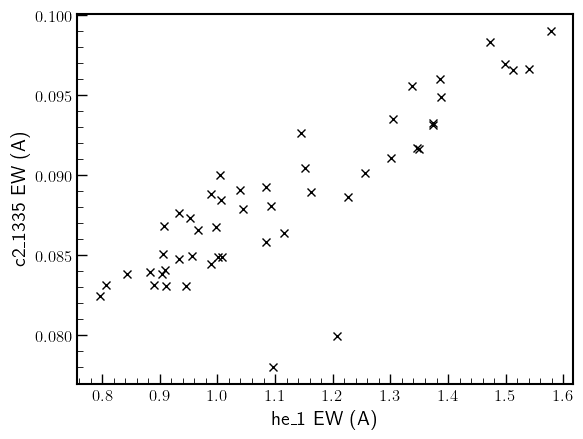

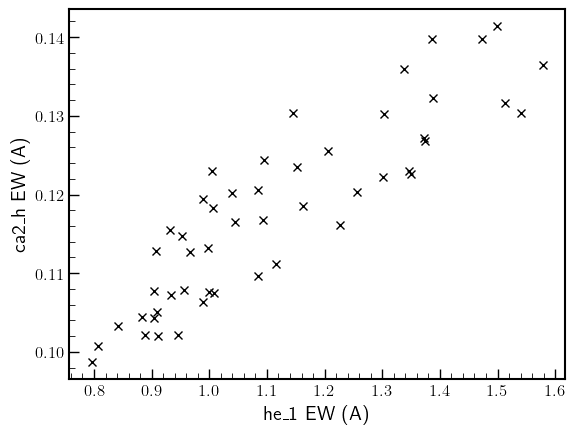

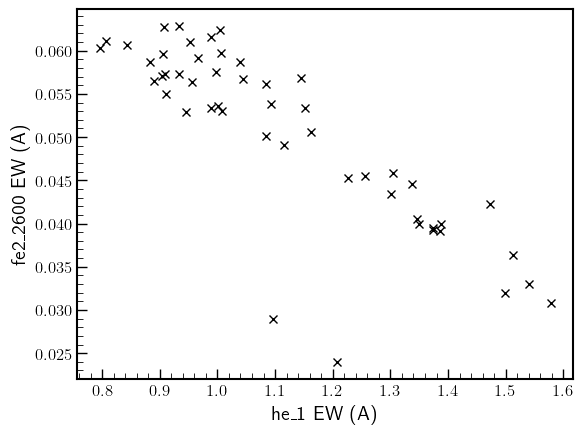

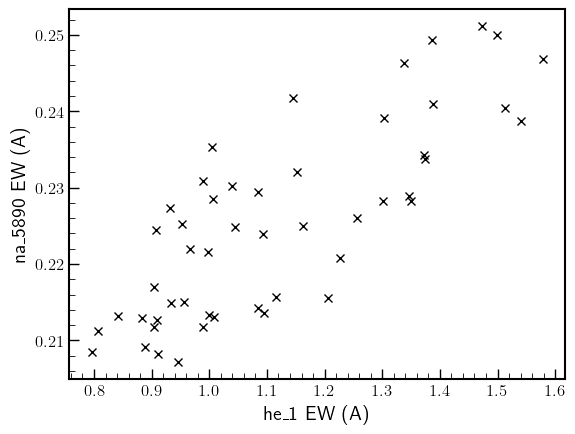

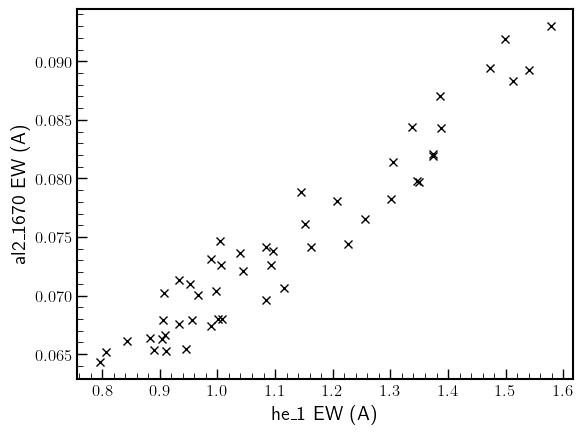

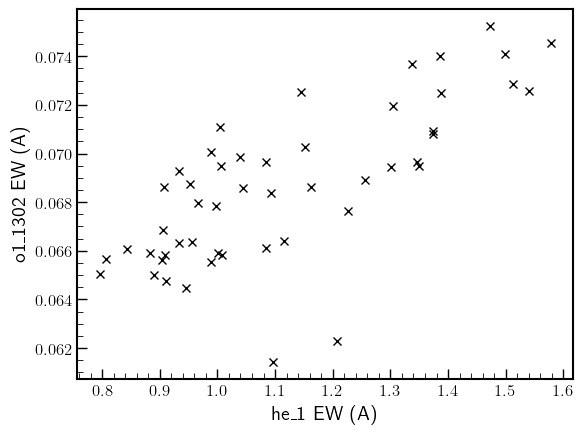

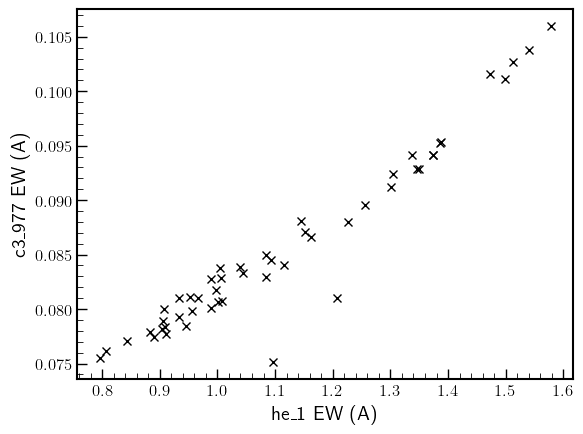

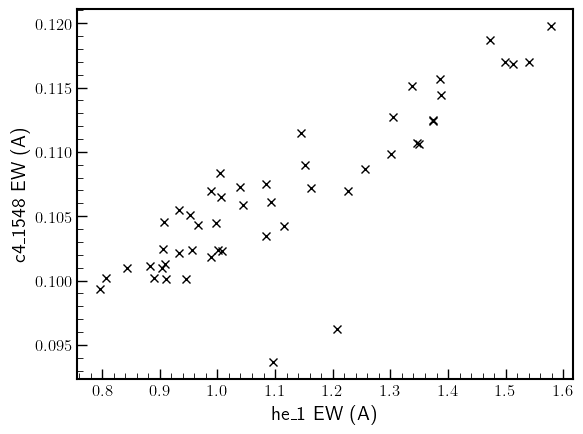

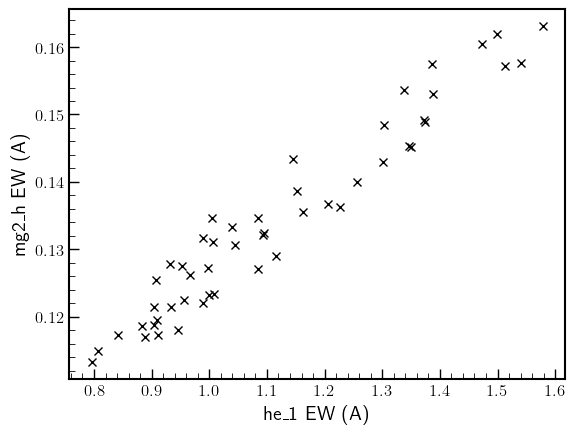

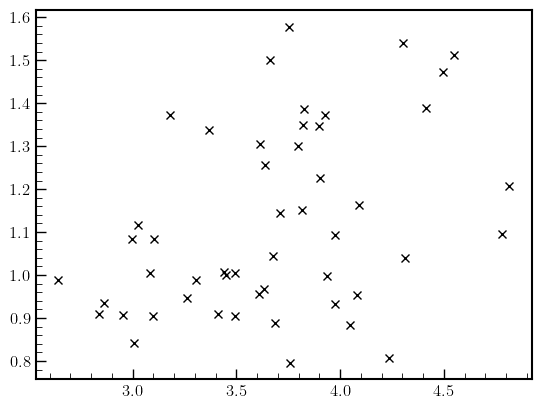

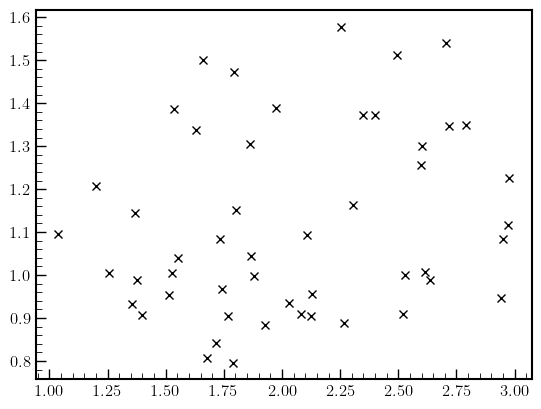

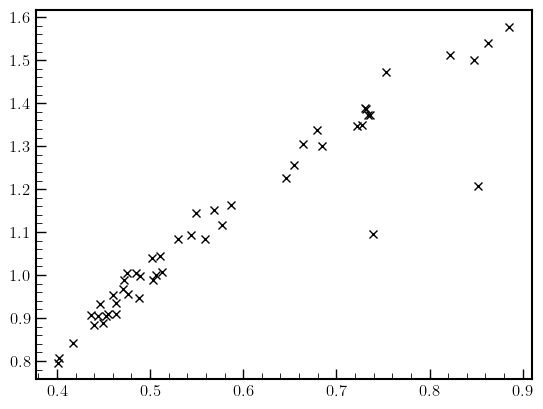

In [66]:
for i, line in enumerate(lines):
    if i > 0:
        plt.plot(EWsK[:, 0]*1e8, EWsK[:, i]*1e8, 'black', linestyle = '', marker = 'x')
        plt.xlabel(species_state[0] + ' EW (A)')
        plt.ylabel(lines[i][0] + ' EW (A)')
        plt.show()

plt.plot(np.log10(Kstars['Feuvp']), EWsK[:, 0]*1e8, 'black', linestyle = '', marker = 'x')
plt.show()
plt.plot(Kstars['period'], EWsK[:, 0]*1e8, 'black', linestyle = '', marker = 'x')
plt.show()
plt.plot(Kstars['mass'], EWsK[:, 0]*1e8, 'black', linestyle = '', marker = 'x')
plt.show()

In [72]:
Kstars

,Star,EW,log(Lx/Lbol),logRhk,B-V,mass,radius,Lbol,stellar_type,period,ap,Feuvp
0,72905,175,-4.46,-4.38,0.619,0.851531,0.910637,0.543232,early-K,1.201615,3.136075e+11,65259.554629
1,20630,210,-4.63,-4.43,0.679,0.446400,0.494647,0.043204,late-K,1.353840,2.737973e+11,9491.253549
2,114710,50,-5.66,-4.75,0.571,0.732100,0.789450,0.300410,late-K,1.535778,3.511979e+11,6693.686917
3,114710,50,-5.66,-4.75,0.571,0.475438,0.525000,0.055311,late-K,1.256679,2.660666e+11,3116.207429
4,35296,257,-4.39,-4.38,0.527,0.752748,0.810475,0.335017,early-K,1.794817,3.932839e+11,31227.494424
5,144284,100,-5.04,-4.47,0.524,0.453057,0.501615,0.045785,late-K,2.124970,3.716169e+11,3132.521803
6,35296,257,-4.39,-4.38,0.527,0.587209,0.640936,0.126551,late-K,2.304892,4.277341e+11,12355.343614
7,126660,133,-4.56,-4.33,0.497,0.863027,0.922251,0.572553,early-K,2.706097,5.412275e+11,19996.920707
8,143761,50,-6.13,-5.03,0.601,0.847669,0.906734,0.533640,early-K,1.659884,3.883919e+11,4598.249077
9,33564,0,-5.96,-4.79,0.477,0.417588,0.464422,0.033261,late-K,1.717347,3.137841e+11,1012.937811


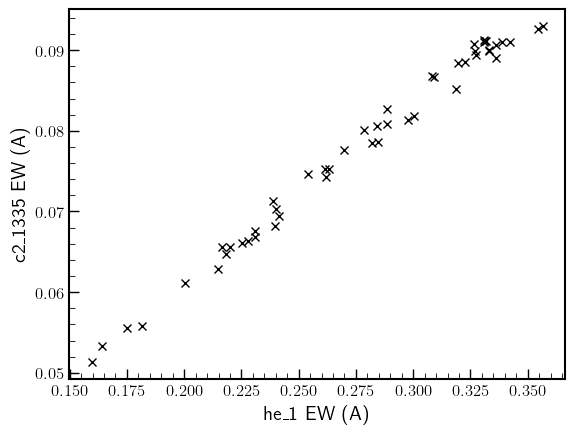

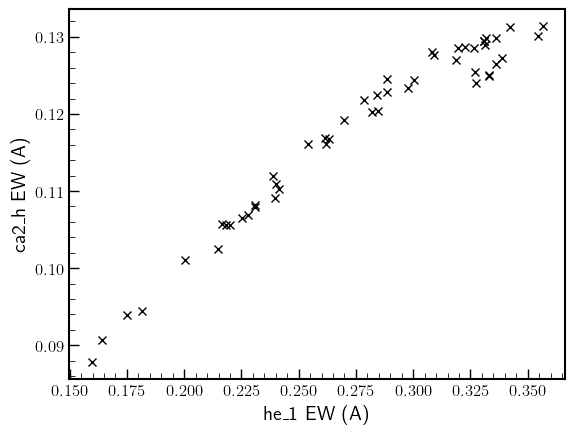

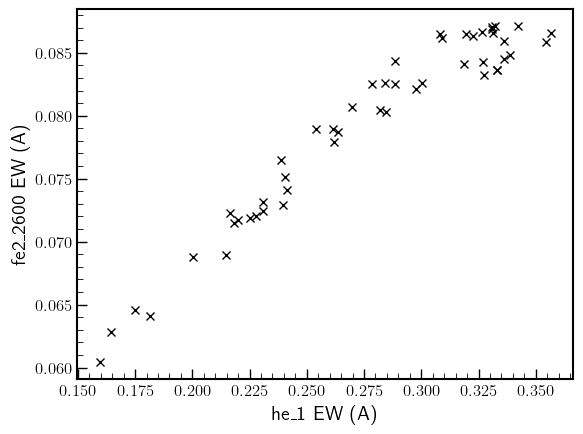

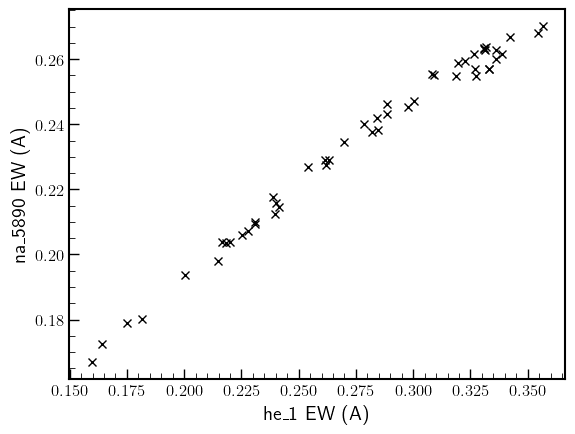

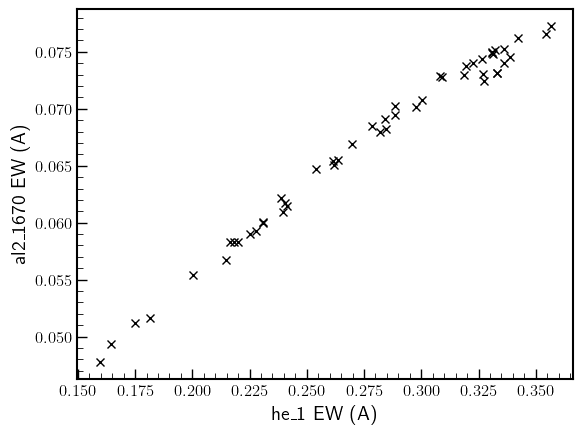

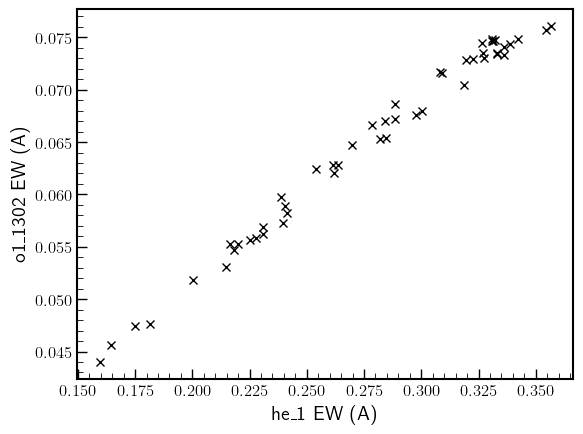

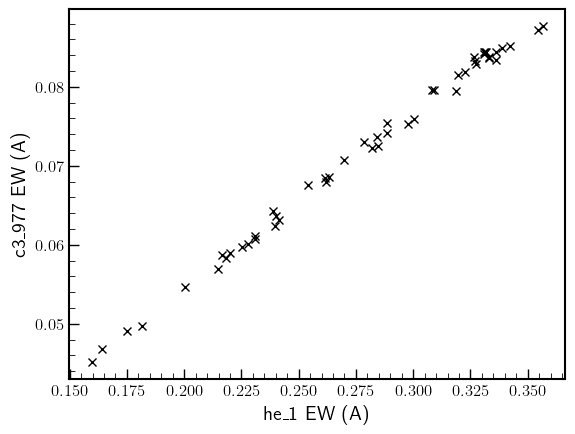

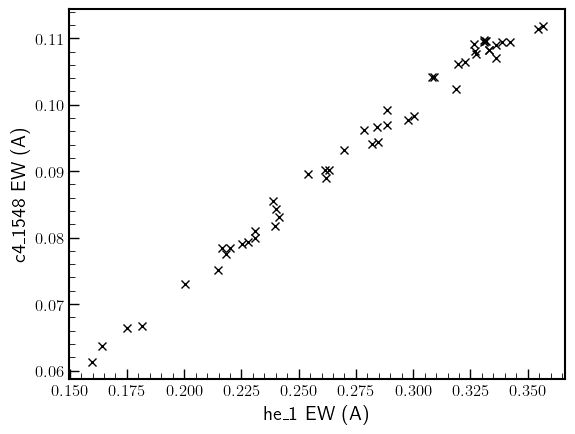

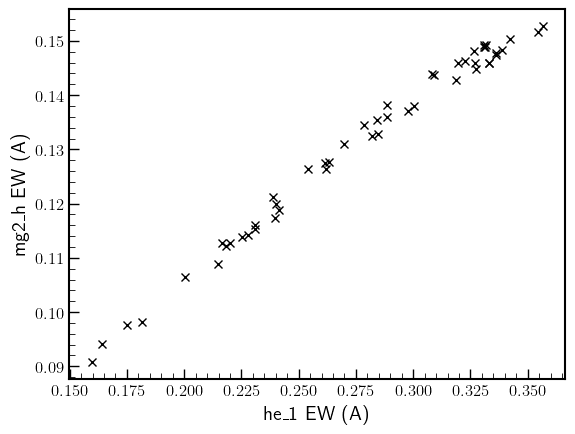

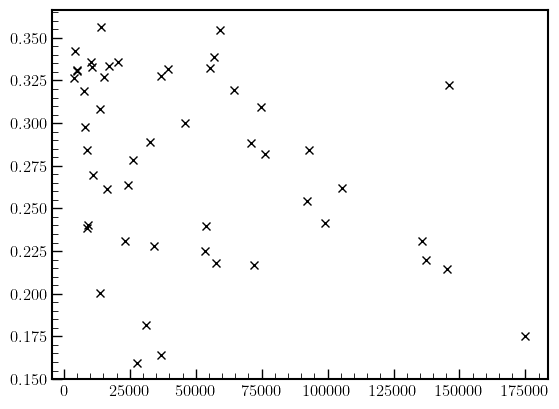

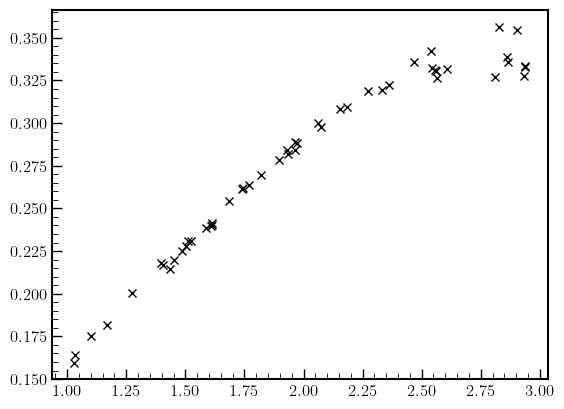

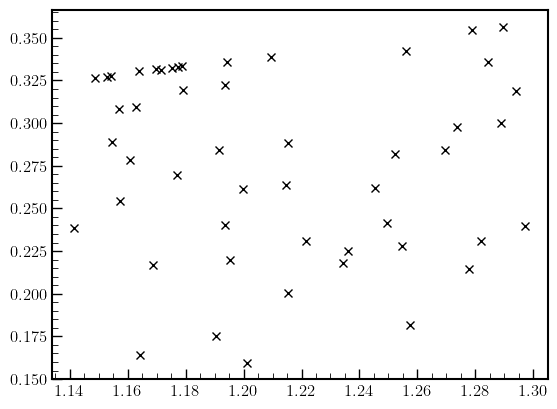

In [71]:
for i, line in enumerate(lines):
    if i > 1:
        plt.plot(EWsF[:, 0]*1e8, EWsF[:, i-1]*1e8, 'black', linestyle = '', marker = 'x')
        plt.xlabel(species_state[0] + ' EW (A)')
        plt.ylabel(lines[i][0] + ' EW (A)')
        plt.show()

plt.plot(Fstars['Feuvp'], EWsF[:, 0]*1e8, 'black', linestyle = '', marker = 'x')
plt.show()
plt.plot(Fstars['period'], EWsF[:, 0]*1e8, 'black', linestyle = '', marker = 'x')
plt.show()
plt.plot(Fstars['mass'], EWsF[:, 0]*1e8, 'black', linestyle = '', marker = 'x')
plt.show()

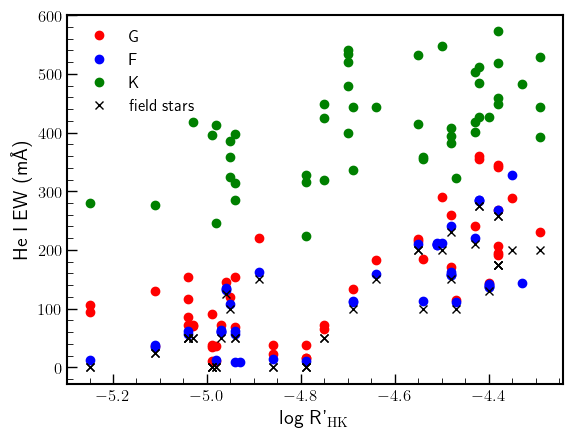

In [72]:
plt.plot(Gstars['logRhk'], Gstars['EWobs'], 'red', linestyle = '', marker = 'o', label='G')
plt.plot(Fstars['logRhk'], Fstars['EWobs'], 'blue', linestyle = '', marker = 'o', label='F')
plt.plot(Kstars['logRhk'], Kstars['EWobs'], 'green', linestyle = '', marker = 'o', label='K')
plt.plot(Gstars['logRhk'], Gstars['EW'], 'black', linestyle = '', marker = 'x', label='field stars')

plt.xlabel('log R\'' + r'$_{\mathrm{HK}}$')
plt.ylabel('He I EW (m\AA)')
#plt.ylim(0, 500)
plt.legend()

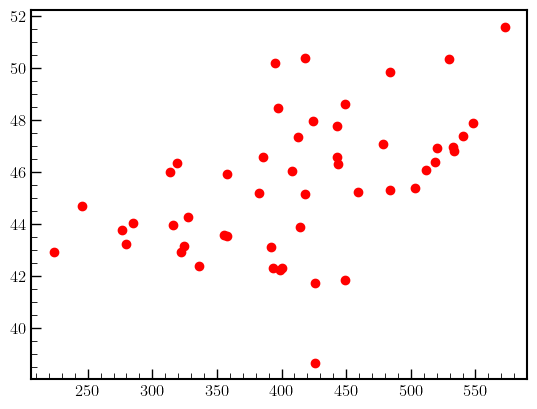

In [66]:
plt.plot(Kstars['EWobs'], Kstars['EWc2'], 'red', linestyle = '', marker = 'o')


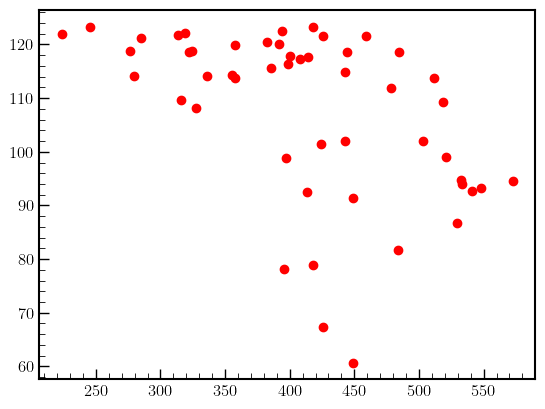

In [69]:
plt.plot(Kstars['EWobs'], Kstars['EWna'], 'red', linestyle = '', marker = 'o')

In [76]:
np.log10(Kstars['EWna'] / 6000000)

28   -4.994849
11   -4.687339
46   -4.817097
46   -4.691598
20   -4.802207
58   -4.704291
20   -4.739419
51   -4.865968
57   -4.881097
19   -4.691698
30   -4.721096
32   -4.782891
9    -4.698546
22   -4.693560
10   -4.812011
22   -4.704399
7    -4.782648
61   -4.703705
9    -4.704077
18   -4.692684
11   -4.706536
65   -4.717769
49   -4.720780
9    -4.840013
62   -4.707734
39   -4.722422
7    -4.712213
56   -4.703575
39   -4.720052
56   -4.699162
12   -4.697527
7    -4.811143
11   -4.769393
62   -4.801750
19   -4.738414
46   -4.772106
30   -4.769221
47   -4.950238
33   -4.808885
18   -4.694947
7    -4.729241
27   -4.690280
40   -4.885300
19   -4.744295
10   -4.687075
7    -4.805206
20   -4.693556
56   -4.714927
22   -4.722312
12   -4.708631
Name: EWna, dtype: float64

In [ ]:
#CII133, FeII237, NaI588

disk = t.Torus(species={'h' : 1, 'he': 0.09}, stellar_spectrum=norm_spectrum, Ms=star['mass']*const.m_sun, Rs=star['radius']*const.r_sun, ap=star['ap'], T=1.0*10**4, Rtorus=[star['ap'], star['ap']+Lcor], i=np.pi/2, tau=0.1)





In [5]:
##synthetic observations of a population of stars with circumstellar gas

#1) randomly draw 36 samples to get a new data set of EW, log(Lx/Lbol) and logRHk
m = 50

cut_stars = stars[stars['logRhk'].notna() & stars['log(Lx/Lbol)'].notna()] 
samples = cut_stars.sample(n=m, replace=True, random_state=320947509)
samples = samples.drop(columns=['Star', 'B-V'])

#2) for each sample randomly draw a stellar type, stellar mass and bolometric luminosity (these will be related)

#L/L_sun = (M/M_sun)^4 which is applicable in between 0.43 and 2 solar mass (source wikipaedia-need to find actual reference)

#K mass: 0.45 - 0.8, #G mass: 0.8-1.04, #F mass: 1.04-1.4 
#Stop at F6 though because this is where the relation stops 

mass = np.random.default_rng(seed=81698123).uniform(0.4, 1.2, m) 
radius = 1.06 * mass**0.945   #Demircan and Kahraman 1990
Lbol = 1.02 * mass**3.92
stellar_type = ['late-K' if m < 0.746
                else 'early-K' if m < 0.908
                else 'late-G' if m < 0.963 
                else 'solar' if m < 1.04 
                else 'early-G' if m < 1.14
                else 'late-F' for m in mass]

samples['mass'] = mass
samples['radius'] = radius
samples['Lbol'] = Lbol
samples['stellar_type'] = stellar_type

#3) for each sample draw planet orbital period (this currently only effects the size of the disc)

period = np.random.default_rng(seed=132914022).uniform(1, 3, m)
samples['period'] = period
samples['ap'] = (const.G * samples['mass'] * const.m_sun * samples['period']**2 * const.day**2 / 4 / np.pi**2)**(1/3)

#4) get EUV luminosity from LX-LEUV relation

#FEUV = a(FX)^(b+1)

LX = samples['Lbol'] * const.Lbol_sun * 10**samples['log(Lx/Lbol)']
FX = LX / (4 * np.pi * (samples['radius'] * const.r_sun)**2)
FEUV = 460 * FX**(1 - 0.425)
LEUV = FEUV * 4 * np.pi * (samples['radius'] * const.r_sun)**2
FEUVp = LEUV / 4 / np.pi / samples['ap']**2

samples['FEUVp'] = FEUVp

#5) flux map of the star to do transit

flux_map_oot = draw.star(100, supersampling=10).intensity
wav = np.linspace(1.0830e-4, 1.0836e-4, 100)

#4)
"""
EW_obs = []

for i, star in samples.iterrows():
    
    base_spectrum = ss.stellar_spectra(star['stellar_type'], semi_major_axis = star['ap'] / (star['radius']*const.r_sun), Lbol=star['Lbol'])
    
    norm_spectrum = base_spectrum.get_rescaled_spectrum(norm_wav=[1.24e-6, 9.12e-6], norm_flux=star['FEUVp'])

    Lcor = 1e6 * star['period'] * const.day / 2 * np.pi

    torus = t.Torus(species={'h' : 1, 'he': 0.09}, stellar_spectrum=norm_spectrum, Ms=star['mass']*const.m_sun, Rs=star['radius']*const.r_sun, ap=star['ap'], T=1.0*10**4, Rtorus=[star['ap'], star['ap']+Lcor], i=np.pi/2, tau=0.1)
    
    i_he3, tau_he3 = torus.do_transit('he_1', ['he_3-2', 'he_3-1', 'he_3-0'], wav, flux_map_oot)
    
    stellar_he3_profile = profile(wav, star['EW']*1e-11, 2.5e4)

    obs_profile = stellar_he3_profile*i_he3

    EW_obs.append(sp_int.trapezoid(1 - obs_profile, wav) * 1e11)

    plt.plot(wav, obs_profile, 'blue')
    plt.plot(wav, i_he3, 'black')
    plt.plot(wav, stellar_he3_profile, 'red')
    plt.show()"""

"\nEW_obs = []\n\nfor i, star in samples.iterrows():\n    \n    base_spectrum = ss.stellar_spectra(star['stellar_type'], semi_major_axis = star['ap'] / (star['radius']*const.r_sun), Lbol=star['Lbol'])\n    \n    norm_spectrum = base_spectrum.get_rescaled_spectrum(norm_wav=[1.24e-6, 9.12e-6], norm_flux=star['FEUVp'])\n\n    Lcor = 1e6 * star['period'] * const.day / 2 * np.pi\n\n    torus = t.Torus(species={'h' : 1, 'he': 0.09}, stellar_spectrum=norm_spectrum, Ms=star['mass']*const.m_sun, Rs=star['radius']*const.r_sun, ap=star['ap'], T=1.0*10**4, Rtorus=[star['ap'], star['ap']+Lcor], i=np.pi/2, tau=0.1)\n    \n    i_he3, tau_he3 = torus.do_transit('he_1', ['he_3-2', 'he_3-1', 'he_3-0'], wav, flux_map_oot)\n    \n    stellar_he3_profile = profile(wav, star['EW']*1e-11, 2.5e4)\n\n    obs_profile = stellar_he3_profile*i_he3\n\n    EW_obs.append(sp_int.trapezoid(1 - obs_profile, wav) * 1e11)\n\n    plt.plot(wav, obs_profile, 'blue')\n    plt.plot(wav, i_he3, 'black')\n    plt.plot(wav, stell

In [ ]:
##circumstellar disk CII133, FeII237, NaI588

In [10]:
samples['EWp'] = EW_obs

In [11]:
samples

,EW,log(Lx/Lbol),logRhk,mass,radius,Lbol,stellar_type,period,ap,FEUVp,EWp
39,100,-5.15,-4.54,0.548132,0.600555,0.096612,late-K,1.201615,2.707789e+11,9131.455237,407.201870
61,25,-6.23,-5.11,0.705704,0.762526,0.260137,late-K,1.353840,3.189544e+11,3410.413977,405.108333
36,200,-4.32,-4.51,0.676708,0.732884,0.220685,late-K,1.535778,3.421072e+11,32695.026699,538.850728
20,257,-4.39,-4.38,0.463701,0.512744,0.050148,late-K,1.256679,2.638589e+11,15773.375895,470.428278
5,50,-6.21,-4.97,0.557076,0.609810,0.102940,late-K,1.794817,3.557359e+11,1366.165269,366.143341
51,133,-4.56,-4.33,0.584924,0.638579,0.124632,late-K,2.124970,4.046482e+11,10892.327182,437.667795
62,200,-4.93,-4.55,0.927106,0.986831,0.758135,late-G,2.304892,4.980652e+11,18009.245336,290.012166
47,130,-4.41,-4.40,0.473298,0.522767,0.054341,late-K,2.706097,4.430131e+11,5801.418551,350.514486
31,0,-5.42,-4.93,0.777174,0.835306,0.379692,early-K,1.659884,3.773120e+11,9565.270196,393.987610
6,320,-4.80,-4.35,0.484006,0.533937,0.059322,late-K,1.717347,3.296085e+11,6696.155811,517.945638


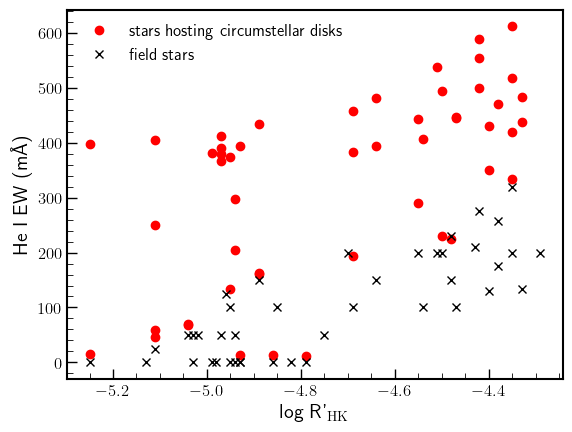

In [13]:
plt.plot(samples['logRhk'], EW_obs, 'red', linestyle = '', marker = 'o', label='stars hosting circumstellar disks')
plt.plot(stars['logRhk'], stars['EW'], 'black', linestyle = '', marker = 'x', label='field stars')

plt.xlabel('log R\'' + r'$_{\mathrm{HK}}$')
plt.ylabel('He I EW (m\AA)')
#plt.ylim(0, 500)
plt.legend()

#plt.savefig('paper_plots/HeEW_obs2.pdf', bbox_inches='tight')

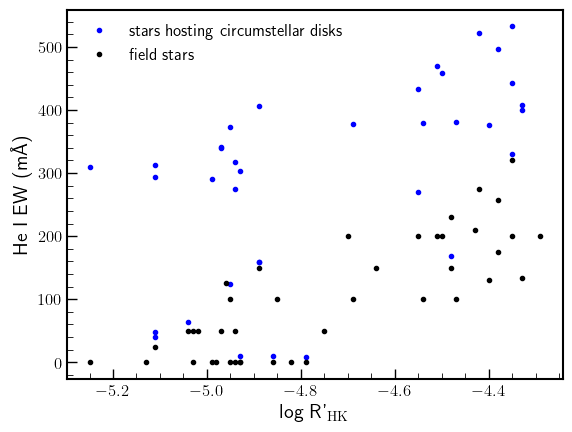

In [20]:
plt.plot(samples['logRhk'], EW_obs, 'b.', label='stars hosting circumstellar disks')
plt.plot(stars['logRhk'], stars['EW'], 'black', linestyle = '', marker = '.', label='field stars')

plt.xlabel('log R\'' + r'$_{\mathrm{HK}}$')
plt.ylabel('He I EW (m\AA)')
plt.legend()

plt.savefig('paper_plots/HeEW_obs2.pdf', bbox_inches='tight')

(array([0.05153935, 0.01405619, 0.02342698, 0.0046854 , 0.01405619,
        0.01405619, 0.02811237, 0.        , 0.00937079, 0.00937079]),
 array([ 0.16287302,  6.09146071, 12.02004841, 17.94863611, 23.8772238 ,
        29.8058115 , 35.73439919, 41.66298689, 47.59157458, 53.52016228,
        59.44874998]),
 <BarContainer object of 10 artists>)

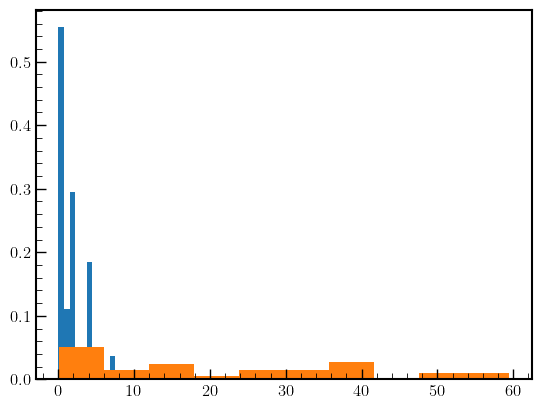

In [67]:
#histogram

def rms(theta, x, y, yerr = 1):

    m, b = theta
    model = m * x + b
    dist = (y - model)**2 / yerr**2
    return dist

plt.hist(rms([w[0], w[1]], x, y, yerr), density=True)
plt.hist(rms([w[0], w[1]], samples['logRhk'], EW_obs, yerr=yerr), density=True)


#plt.savefig('torihist.pdf')

In [46]:
#bootstrap histogram

data = np.stack((x, y), axis = 0)

def rms1(data, axis=0):

    np.sum(

    model = w[0] * x1 + w[1]
    dist = (y1 - model)**2 
    return dist

In [48]:
sp_stats.bootstrap(data, rms1, vectorized=True, axis=1)

IndexError: tuple index out of range

In [38]:
data

array([[ -4.97,  50.  ],
       [ -4.35, 320.  ],
       [ -4.7 , 200.  ],
       [ -4.96, 125.  ],
       [ -4.29, 200.  ],
       [ -4.98,   0.  ],
       [ -4.43, 210.  ],
       [ -4.48, 150.  ],
       [ -4.93,   0.  ],
       [ -4.94,  50.  ],
       [ -4.79,   0.  ],
       [ -4.38, 257.  ],
       [ -4.42, 275.  ],
       [ -4.48, 230.  ],
       [ -4.38, 175.  ],
       [ -5.04,  50.  ],
       [ -4.69, 100.  ],
       [ -4.93,   0.  ],
       [ -4.94,   0.  ],
       [ -4.5 , 200.  ],
       [ -4.51, 200.  ],
       [ -4.86,   0.  ],
       [ -4.54, 100.  ],
       [ -4.99,   0.  ],
       [ -4.75,  50.  ],
       [ -4.4 , 130.  ],
       [ -5.25,   0.  ],
       [ -4.33, 133.  ],
       [ -4.35, 200.  ],
       [ -4.95, 100.  ],
       [ -5.03,  50.  ],
       [ -4.47, 100.  ],
       [ -5.11,  25.  ],
       [ -4.55, 200.  ],
       [ -4.64, 150.  ],
       [ -4.89, 150.  ]])

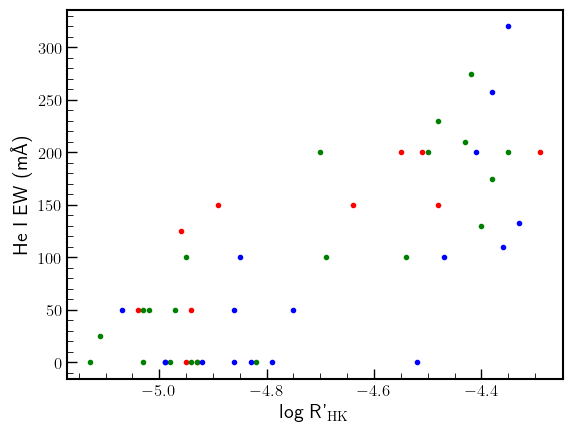

In [22]:
#the trend found in smith only applies to stars with B-




smith_dataK = smith_data[smith_data['B-V'] > 0.81]
smith_dataG = smith_data[(smith_data['B-V'] > 0.58) & (smith_data['B-V'] < 0.81)]
smith_dataF = smith_data[(smith_data['B-V'] > 0.30) & (smith_data['B-V'] < 0.58)]


plt.plot(smith_dataK['logRhk'], smith_dataK['EW'],  'r.', label = 'K')
plt.plot(smith_dataG['logRhk'], smith_dataG['EW'],  'g.', label = 'G')
plt.plot(smith_dataF['logRhk'], smith_dataF['EW'], 'b.', label = 'F')
plt.xlabel('log R\'' + r'$_{\mathrm{HK}}$')
plt.ylabel('He I EW (m\AA)')
plt.savefig('smithRhkcoded.pdf')

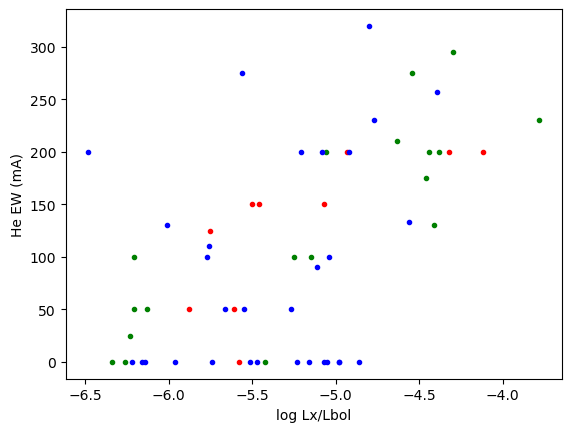

In [6]:
plt.plot(smith_dataK['log(Lx/Lbol)'], smith_dataK['EW'], 'r.', label = 'K')
plt.plot(smith_dataG['log(Lx/Lbol)'], smith_dataG['EW'], 'g.', label = 'F')
plt.plot(smith_dataF['log(Lx/Lbol)'], smith_dataF['EW'], 'b.', label = 'G')
plt.xlabel('log Lx/Lbol')
plt.ylabel('He EW (mA)')
plt.savefig('smithLxcoded.pdf')

In [ ]:
x = cut_stars['logRhk'].values
y = cut_stars['EW'].values
yerr = np.ones(len(x)) * 40

A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(-5.5, -4, 500)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");

In [8]:
#table without nans

smith_data_noNAN = smith_data[smith_data['logRhk'].notna()]


x = smith_data_noNAN['logRhk'].values
y = smith_data_noNAN['EW'].values
yerr = np.ones(len(x)) * 40

Least-squares estimates:
m = 259.224 ± 21.110
b = 1323.312 ± 100.205


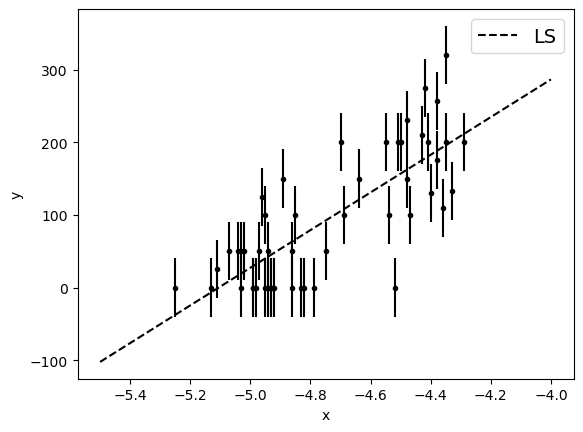

In [9]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(-5.5, -4, 500)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");

In [10]:
#make a quick mcmc in order to find a straight line fit of the points

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model)**2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    m, b, log_f = theta
    return 0.0

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Maximum likelihood estimates:
m = 237.598
b = 1219.075
f = 0.380


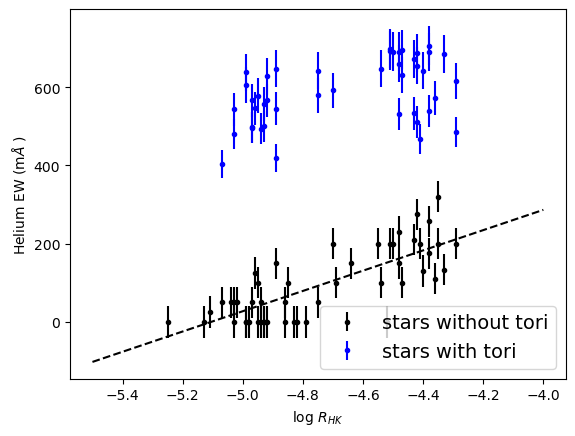

In [29]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([w[0], w[1], 1]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label = 'stars without tori')
plt.errorbar(samples['logRhk'], samples['EWp'] - 300, yerr=samples['EWp']*0.05, fmt=".b", capsize=0, label = 'stars with tori') #synthetic data
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k") #,label="LS")
#plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.ylabel(r"Helium EW (m$\AA~$)")
plt.xlabel(r"log $R_{HK}$");
#plt.savefig('tori.pdf')

In [12]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 898.84it/s]


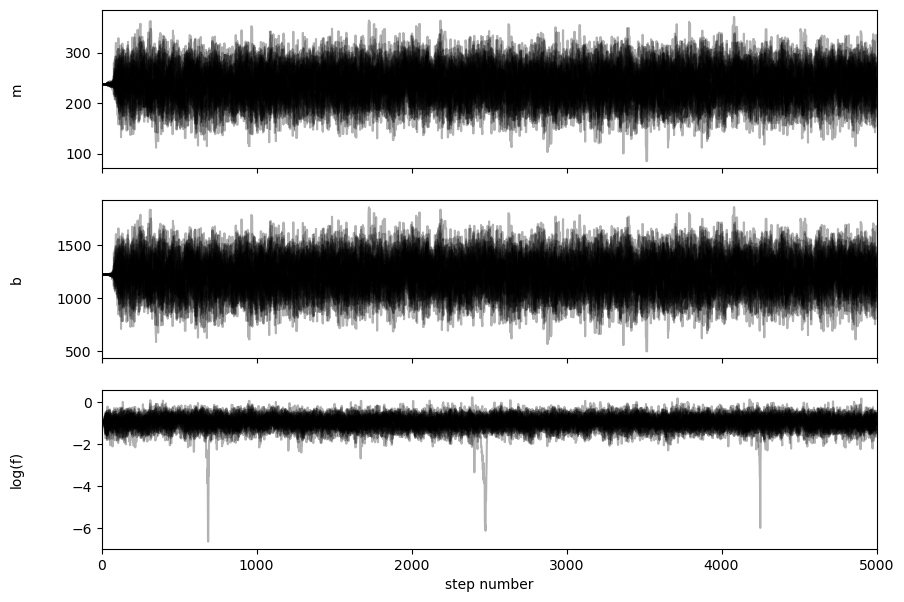

In [13]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [11]:
tau = sampler.get_autocorr_time()
print(tau)

[36.99796526 36.96818931 36.61483497]


In [12]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


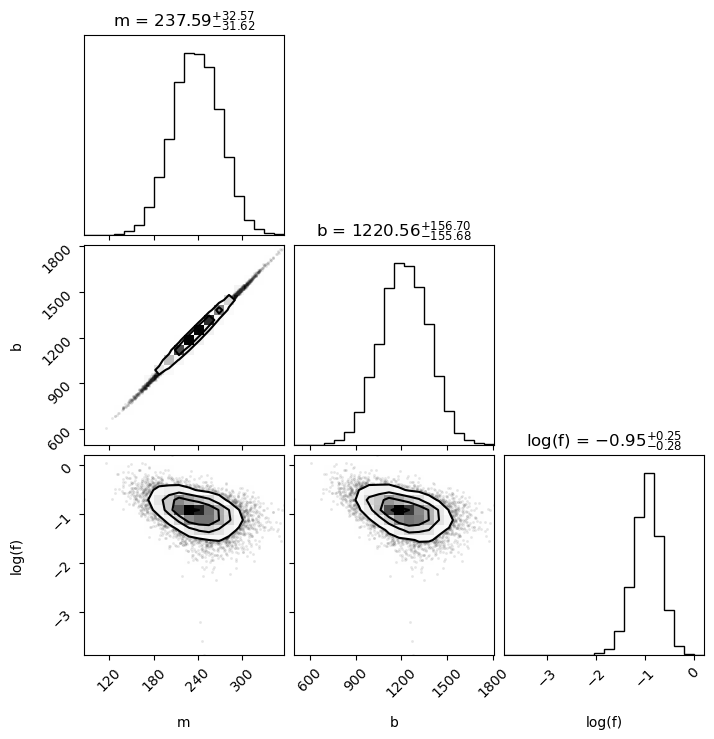

In [13]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, show_titles=True
);

In [ ]:
#taking the maximum likelihood estimates for a straight line through the points, create histogram of distances

def rms(theta, x, y, yerr = 1):

    m, b, log_f = theta
    model = m * x + b
    dist = (y - model)**2 / yerr**2
    return dist

plt.hist(rms(soln.x, x, y, yerr))
plt.hist(rms(soln.x, samples['logRhk'], samples['EWp'], yerr= samples['EWp']*0.1))
plt.savefig('torihist.pdf')


In [17]:
#steps

#1) randomly draw 50 samples to get a new data set of EW, log(Lx/Lbol) and logRHk
m = 50

samples = smith_data_noNAN.sample(n=m, replace=True)
samples = samples.drop(columns=['Star', 'B-V'])

#2) for each sample randomly draw a stellar type, stellar mass and bolometric luminosity (these will be related)

#Use mass-luminosity relation:

#L/L_sun = (M/M_sun)^4 which is applicable in between 0.43 and 2 solar mass (source wikipaedia-need to find actual reference)

#K mass: 0.45 - 0.8, #G mass: 0.8-1.04, #F mass: 1.04-1.4 (source wikipaedia-need to find actual reference)

mass = np.random.default_rng().uniform(0.45, 1.4, m) 
radius = 0.89 * mass**0.89
Lbol = mass**4   #do I want to draw in mass space or luminosity space (and how do I want to do these draws)
type = ['K' if m < 0.8 else 'G' if m < 1.04 else 'F' for m in mass] 

samples['mass'] = mass
samples['radius'] = radius
samples['Lbol'] = Lbol
samples['type'] = type

#calculate LEUV using LX-LEUV relations

#for now just use LEUV = 100 LX

samples['LEUV'] = samples['Lbol'] * 100 * 10**samples['log(Lx/Lbol)']

#3) for each sample draw planet orbital period (this currently only effects the size of the disc)

period = np.random.default_rng().uniform(1, 3, m)

samples['period'] = period


#4) run through EW calculator to find new equivalent equivalent width

EWwithplanet = []
for index, star in samples.iterrows():

    a = (G * star['mass'] * 2e33 * (star['period'] * 60 * 60 * 24)**2 / (4 * np.pi**2))**(1/3)
    FEUV = star['LEUV'] *  3.8e33 / (4 * np.pi * a**2)
    spec = normalize_spectrum(ss, FEUV)
    torus1 = torus.Torus({'h': 1, 'he' : 0.11}, spec, star['mass'] * 2e33, star['radius'] * 7e10, a, 10**4, a, tau = 1)
    torus1.calculate_ion_abundances_all_species()
    EW = torus1.get_EW()
    EWwithplanet.append(EW)

samples['EWp'] = EWwithplanet

#need to consider the initial spectral shape of the helium line 

0.1364920437335968
(312, 400)
0.0014088148018345237
(312, 400)
0.37238919734954834
(312, 400)
0.004748662002384663
(312, 400)
0.0009039882570505142
(312, 400)
0.14521479606628418
(312, 400)
0.01862986385822296
(312, 400)
0.41718047857284546
(312, 400)
0.0446031279861927
(312, 400)
0.0003806808963418007
(312, 400)
1.2444372177124023
(312, 400)
0.03497224301099777
(312, 400)
0.004810664802789688
(312, 400)
0.24009449779987335
(312, 400)
0.004441443830728531
(312, 400)
0.27526307106018066
(312, 400)
0.006955502554774284
(312, 400)
0.002976581919938326
(312, 400)
nan
(312, 400)
0.0003313890192657709
(312, 400)
nan
(312, 400)
0.021501697599887848
(312, 400)
0.005640576593577862
(312, 400)
0.017717648297548294
(312, 400)
nan
(312, 400)
0.052072733640670776
(312, 400)
0.09301254153251648
(312, 400)
0.05460225045681
(312, 400)
nan
(312, 400)
0.07417947798967361
(312, 400)
0.812669038772583
(312, 400)
0.03322836756706238
(312, 400)
0.03508628532290459
(312, 400)
0.013637227937579155
(312, 400)


In [31]:
samples

,EW,log(Lx/Lbol),logRhk,mass,radius,Lbol,type,LEUV,period,EWp
50,0,-5.05,-4.92,1.379193,1.184831,3.618268,F,0.003225,1.925738,834.390607
57,50,-6.13,-5.03,0.692422,0.641683,0.229871,K,0.000017,2.792074,823.653944
22,275,-4.54,-4.42,0.559089,0.530455,0.097707,K,0.000282,1.318974,948.169261
19,0,-5.96,-4.79,1.035483,0.918052,1.149665,G,0.000126,1.274547,734.942869
68,0,NaN,-5.03,0.718551,0.663189,0.266582,K,NaN,2.075778,NaN
59,50,NaN,-5.02,0.929453,0.833897,0.746292,G,NaN,2.320567,NaN
44,0,-4.98,-4.99,0.968265,0.864818,0.878975,G,0.000920,2.576707,988.191458
27,230,-3.78,-4.48,1.174426,1.026916,1.902405,F,0.031572,2.791920,1008.691874
25,0,-6.14,-4.52,0.715401,0.660601,0.261938,K,0.000019,1.341858,772.881428
27,230,-3.78,-4.48,1.350047,1.162520,3.321966,F,0.055131,1.017727,653.832799


In [ ]:
for i in samples:
    print(i['mass'])

In [28]:
EWwithplanet

[811.4244891563786,
 916.0722379682743,
 805.9251401581226,
 972.1415505233003,
 949.421980526741]

In [15]:
#constants 

c = 2.9979e10
mp = 1.67e-24
k_b = 1.3807e-16
m_e = 9.11e-28
e = 4.803e-10
G = 6.67e-8

In [16]:
##turn .sav file of solar spectrum into usable python solar spectrum 
"""** Structure <20abc08>, 6 tags, length=165722064, data length=165722064, refs=1:
   WAVELENGTH      FLOAT     Array[920]			(nm)
   DATE_YD         DOUBLE    Array[14989]		(YYYYDOY date format)
   DATE_JD         DOUBLE    Array[14989]		(Julian Day format)
   IRRADIANCE      FLOAT     Array[14989, 920]	(mW/m^2/nm)
   FLAG_SOURCE     FLOAT     Array[14989, 920]	(number from -1 to 139 that represents data source)
   MODEL           FLOAT     Array[14989, 920]	(mW/m^2/nm)
   UNCERTAINTY_IRRADIANCE   FLOAT     Array[920]    (unitless, % relative accuracy)
   UNCERTAINTY_MODEL        FLOAT     Array[920]    (unitless, % relative accuracy)"""



ss_idl = sp_io.readsav('ssi3_ext_0nm_1600nm.sav')
ss_wav = ss_idl['ssi3_ext'][0][0] #nm
ss_irr = ss_idl['ssi3_ext'][0][3][:, 1000] #mw/m^2/nm
ss_mod = ss_idl['ssi3_ext'][0][5][:, 1000] #mw/m^2/nm

#turn into cgs
ss_wav_cgs = ss_wav * 1e-7
ss_irr_cgs = ss_irr * 1e7
ss_nu_cgs = c / ss_wav_cgs
ss_irr_nu_cgs = ss_irr_cgs * ss_wav_cgs**2 / c

ss = {'wl' : ss_wav_cgs, 'F_wl' : ss_irr_cgs, 'nu' : ss_nu_cgs, 'F_nu' : ss_irr_nu_cgs}

def get_spectra(fits_file):
    spec = fits.getdata(fits_file,1)
    wav = spec['WAVELENGTH'] * 1e-8       #in angstroms so turn into cgs 
    irr_wav = spec['FLUX'] * 1e8          
    nu = c / wav
    irr_nu = irr_wav * wav**2 / c
    return {'wl' : wav, 'F_wl': irr_wav, 'nu' : nu, 'F_nu' : irr_nu}


K6 = get_spectra('hlsp_muscles_multi_multi_hd85512_broadband_v22_adapt-const-res-sed.fits')
K2 = get_spectra('hlsp_muscles_multi_multi_v-eps-eri_broadband_v22_adapt-const-res-sed.fits')
G5 = get_spectra('hlsp_muscles_multi_multi_wasp-127_broadband_v24_adapt-const-res-sed.fits')
F4 = get_spectra('hlsp_muscles_multi_multi_wasp-43_broadband_v24_adapt-const-res-sed.fits')


def normalize_spectrum(stellar_spectrum, Feuv, euv_range = [1e-6, 1.17e-5]):

    normalized_stellar_spectrum = deepcopy(stellar_spectrum)
    euv_mask = (stellar_spectrum['wl'] > euv_range[0]) & (stellar_spectrum['wl'] < euv_range[1])
    Feuv_ss = sp_int.trapezoid(stellar_spectrum['F_wl'][euv_mask], stellar_spectrum['wl'][euv_mask])
    normalized_stellar_spectrum['F_wl'] *= (Feuv / Feuv_ss)
    normalized_stellar_spectrum['F_nu'] *= (Feuv / Feuv_ss)
    
    return normalized_stellar_spectrum

norm_ss = normalize_spectrum(ss, 10**4)

In [ ]:
testTorus = torus.Torus({'h': 1, 'he' : 0.11}, norm_ss, 1e33, 7e10, 0.02*1.5e13, 10**4, 0.02*1.5e13, tau = 1)

In [ ]:
testTorus.calculate_ion_abundances_all_species()
testTorus.get_EW()

In [ ]:
(5 & 1) == 1

In [ ]:
K6['wl']

In [ ]:
normalize_spectrum(K6, 10**4)